# Clustering analysis using appraisal theory to derive facial expressions

The purpose of this analysis is to derive facial expression from data based on psychologically meaningful annotations, and then use these facial factors to train a classifier to predict outcomes.  This analysis is inspired by Stratou et al (2017) and Hoegen et al (2023), but draw from appraisal theory of emotions to form meaningful emotions clusters.  Using appraisals to understanding facial expressions in not new, and work is done by both Ong et all (2021) or Houlihan et al (2022), Houlihan et al (2023).

In [1]:
##### Standard packages
import numpy as np
import pandas as pd
import os
import math
import random
import re

# scipy
import scipy
import scipy.spatial.distance

##### Plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

##### Clustering 
# Dynamic time warping
from dtaidistance import dtw
import dtaidistance.clustering
from tslearn import barycenters

# factor analysis
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# Decision trees and random forrests
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier

## metrics 
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score

## misc
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE # oversampling for imbalanced datasets


##### Saving 
import pickle


## Data loading and cleaning

First thing we do is that we find all relevant participant and file names

Now we load all the files

In [2]:
d_au_annotation_unfiltered = pd.read_csv("../data/d_au_annotation.csv")
d_au_annotation_unfiltered.rename(columns=lambda x: x[:-2] if x.endswith("_r") else x, inplace=True)

## Factor analysis for all participants

First we add factors from the factor analysis conducted in R

In [3]:
d_au_pleasantness = d_au_annotation_unfiltered.query("~(pleasantness != pleasantness)").copy() # remove na

# define the factors
f1 = ["AU06", "AU07", "AU09", "AU10"]
f1_weights = [0.854, 0.712, 0.302, 0.735]
f2 = ["AU01", "AU02"]
f2_weights = [0.986, 0.800]
f3 = ["AU15", "AU17"]
f3_weights = [0.324, 0.991]
f4 = ["AU12", "AU14"]
f4_weights = [0.776, 0.458]
f5 = ["AU25", "AU26"]
f5_weights = [0.781, 0.689]
f6 = ["AU23"]
f6_weights = [0.817]
f7 = ["AU09", "AU15"]
f7_weights = [0.304, 0.328]


# Create expressivity metrics
# # mean activation
# d_au_pleasantness["f1_mean"]  = d_au_pleasantness[f1].mean(axis=1)
# d_au_pleasantness["f2_mean"]  = d_au_pleasantness[f2].mean(axis=1)
# d_au_pleasantness["f3_mean"]  = d_au_pleasantness[f3].mean(axis=1)
# d_au_pleasantness["f4_mean"]  = d_au_pleasantness[f4].mean(axis=1)
# d_au_pleasantness["f5_mean"]  = d_au_pleasantness[f5].mean(axis=1)
# d_au_pleasantness["f6_mean"]  = d_au_pleasantness[f6].mean(axis=1)
# d_au_pleasantness["f7_mean"]  = d_au_pleasantness[f7].mean(axis=1)

# weighted mean activation
d_au_pleasantness["f1_mean"]  = d_au_pleasantness[f1].mul(f1_weights).sum(axis=1)/len(f1)
d_au_pleasantness["f2_mean"]  = d_au_pleasantness[f2].mul(f2_weights).sum(axis=1)/len(f2)
d_au_pleasantness["f3_mean"]  = d_au_pleasantness[f3].mul(f3_weights).sum(axis=1)/len(f3)
d_au_pleasantness["f4_mean"]  = d_au_pleasantness[f4].mul(f4_weights).sum(axis=1)/len(f4)
d_au_pleasantness["f5_mean"]  = d_au_pleasantness[f5].mul(f5_weights).sum(axis=1)/len(f5)
d_au_pleasantness["f6_mean"]  = d_au_pleasantness[f6].mul(f6_weights).sum(axis=1)/len(f6)
d_au_pleasantness["f7_mean"]  = d_au_pleasantness[f7].mul(f7_weights).sum(axis=1)/len(f7)

# # sum variables
# d_au_pleasantness["f1_sum"]  = d_au_pleasantness[f1].sum(axis=1)
# d_au_pleasantness["f2_sum"]  = d_au_pleasantness[f2].sum(axis=1)
# d_au_pleasantness["f3_sum"]  = d_au_pleasantness[f3].sum(axis=1)
# d_au_pleasantness["f4_sum"]  = d_au_pleasantness[f4].sum(axis=1)
# d_au_pleasantness["f5_sum"]  = d_au_pleasantness[f5].sum(axis=1)
# d_au_pleasantness["f6_sum"]  = d_au_pleasantness[f6].sum(axis=1)
# d_au_pleasantness["f7_sum"]  = d_au_pleasantness[f7].sum(axis=1)

# weighted sum variables
d_au_pleasantness["f1_sum"]  = d_au_pleasantness[f1].mul(f1_weights).sum(axis=1)
d_au_pleasantness["f2_sum"]  = d_au_pleasantness[f2].mul(f2_weights).sum(axis=1)
d_au_pleasantness["f3_sum"]  = d_au_pleasantness[f3].mul(f3_weights).sum(axis=1)
d_au_pleasantness["f4_sum"]  = d_au_pleasantness[f4].mul(f4_weights).sum(axis=1)
d_au_pleasantness["f5_sum"]  = d_au_pleasantness[f5].mul(f5_weights).sum(axis=1)
d_au_pleasantness["f7_sum"]  = d_au_pleasantness[f7].mul(f7_weights).sum(axis=1)


# # sd
# d_au_pleasantness["f1_sd"]  = d_au_pleasantness[f1].std(axis=1)
# d_au_pleasantness["f2_sd"]  = d_au_pleasantness[f2].std(axis=1)
# d_au_pleasantness["f3_sd"]  = d_au_pleasantness[f3].std(axis=1)
# d_au_pleasantness["f4_sd"]  = d_au_pleasantness[f4].std(axis=1)
# d_au_pleasantness["f5_sd"]  = d_au_pleasantness[f5].std(axis=1)
# d_au_pleasantness["f6_sd"]  = 0 # as it's only one AU
# d_au_pleasantness["f7_sd"]  = d_au_pleasantness[f7].std(axis=1)

# sd
d_au_pleasantness["f1_sd"]  = d_au_pleasantness[f1].mul(f1_weights).std(axis=1)
d_au_pleasantness["f2_sd"]  = d_au_pleasantness[f2].mul(f2_weights).std(axis=1)
d_au_pleasantness["f3_sd"]  = d_au_pleasantness[f3].mul(f3_weights).std(axis=1)
d_au_pleasantness["f4_sd"]  = d_au_pleasantness[f4].mul(f4_weights).std(axis=1)
d_au_pleasantness["f5_sd"]  = d_au_pleasantness[f5].mul(f5_weights).std(axis=1)
d_au_pleasantness["f7_sd"]  = d_au_pleasantness[f7].mul(f7_weights).std(axis=1)


# change variables
d_au_pleasantness["f1_change"]  = d_au_pleasantness["f1_mean"].diff().fillna(0)
d_au_pleasantness["f2_change"]  = d_au_pleasantness["f2_mean"].diff().fillna(0)
d_au_pleasantness["f3_change"]  = d_au_pleasantness["f3_mean"].diff().fillna(0)
d_au_pleasantness["f4_change"]  = d_au_pleasantness["f4_mean"].diff().fillna(0)
d_au_pleasantness["f5_change"]  = d_au_pleasantness["f5_mean"].diff().fillna(0)
d_au_pleasantness["f6_change"]  = d_au_pleasantness["f6_mean"].diff().fillna(0)
d_au_pleasantness["f7_change"]  = d_au_pleasantness["f7_mean"].diff().fillna(0)

# max
# d_au_pleasantness["f1_max"]  = d_au_pleasantness[f1].max(axis=1)
# d_au_pleasantness["f2_max"]  = d_au_pleasantness[f2].max(axis=1)
# d_au_pleasantness["f3_max"]  = d_au_pleasantness[f3].max(axis=1)
# d_au_pleasantness["f4_max"]  = d_au_pleasantness[f4].max(axis=1)
# d_au_pleasantness["f5_max"]  = d_au_pleasantness[f5].max(axis=1)
# d_au_pleasantness["f6_max"]  = d_au_pleasantness[f6].max(axis=1)
# d_au_pleasantness["f7_max"]  = d_au_pleasantness[f7].max(axis=1)
# max
d_au_pleasantness["f1_max"]  = d_au_pleasantness[f1].mul(f1_weights).max(axis=1)
d_au_pleasantness["f2_max"]  = d_au_pleasantness[f2].mul(f2_weights).max(axis=1)
d_au_pleasantness["f3_max"]  = d_au_pleasantness[f3].mul(f3_weights).max(axis=1)
d_au_pleasantness["f4_max"]  = d_au_pleasantness[f4].mul(f4_weights).max(axis=1)
d_au_pleasantness["f5_max"]  = d_au_pleasantness[f5].mul(f5_weights).max(axis=1)
d_au_pleasantness["f7_max"]  = d_au_pleasantness[f7].mul(f7_weights).max(axis=1)


d_au_pleasantness.pleasantness.value_counts()

pleasantness
Medium    94980
Low       14094
High       7716
Name: count, dtype: int64

# Random Forests

In [4]:
# Base model
X = d_au_pleasantness.copy()
y = d_au_pleasantness["pleasantness"]
average_classification = []
f1_score_list = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

    #Predict the response for test dataset
    y_pred = ["Medium"] * len(y_test)

    average_classification.append(metrics.accuracy_score(y_test, y_pred))
    
    # Calculate F1 score for each class separately

    # f1_per_class = f1_score(y_test, y_pred, average=None)
    # print(f1_per_class)

    # Calculate micro-average F1 score
    # f1_micro = f1_score(y_test, y_pred, average='micro')

    # Calculate macro-average F1 score
    # f1_macro = f1_score(y_test, y_pred, average='macro')

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))

print(np.mean(average_classification))
print(np.mean(f1_score_list))

Accuracy: 0.8126837343379856
F1: 0.7287038985857506
Accuracy: 0.8129976881582327
F1: 0.729140743275944
Accuracy: 0.8090019122641778
F1: 0.7235858509711943
Accuracy: 0.8157091075149128
F1: 0.7329162422866908
Accuracy: 0.811456460313383
F1: 0.7269968684429883
Accuracy: 0.8123983217741245
F1: 0.7283068244902814
Accuracy: 0.8115135428261552
F1: 0.7270762427343964
Accuracy: 0.8105145988526415
F1: 0.7256875093628852
Accuracy: 0.814681622285013
F1: 0.7314849475945144
Accuracy: 0.8142249621828352
F1: 0.7308490433777055
0.8125181950509461
0.728474817112235


### AU model

In [6]:
#split dataset in features and target variable
feature_cols_au = [col_name for col_name in d_au_pleasantness.columns if "au" in col_name.lower()]
X_au = d_au_pleasantness[feature_cols_au] # Features
y_au = d_au_pleasantness["pleasantness"] # Target variable


X_train_au, X_test_au, y_train_au, y_test_au = train_test_split(X_au, y_au, test_size=0.3, random_state=1) # 70% training and 30% test

In [6]:
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_au)))]}

rf = RandomForestClassifier()

grid_seach_au = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_au.fit(X_train_au, y_train_au)

print(grid_seach_au.best_params_)
print(grid_seach_au.score(X_train_au, y_train_au))
best_rf_au = grid_seach_au.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 10}
0.8295353075728108


In [8]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_au))), random_state=1)

average_classification_au = []
f1_score_list_au = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au, y_au, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_au.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_au.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_au))
print(np.mean(f1_score_list_au))

Accuracy: 0.8284670491195022
F1: 0.7612226674828996
Accuracy: 0.8226446328167366
F1: 0.7519162886458789
Accuracy: 0.827353940120444
F1: 0.7593183192021223
Accuracy: 0.8239860718668836
F1: 0.7552001275923053
Accuracy: 0.8247281445329223
F1: 0.7559940559338432
Accuracy: 0.8222735964837172
F1: 0.7512146223584638
Accuracy: 0.8240431543796558
F1: 0.7548938427278025
Accuracy: 0.8268401975054942
F1: 0.7579998076673783
Accuracy: 0.825156263378714
F1: 0.7556189840195535
Accuracy: 0.8223021377401033
F1: 0.7514554134417417
0.8247795187944172
0.7554834129071988


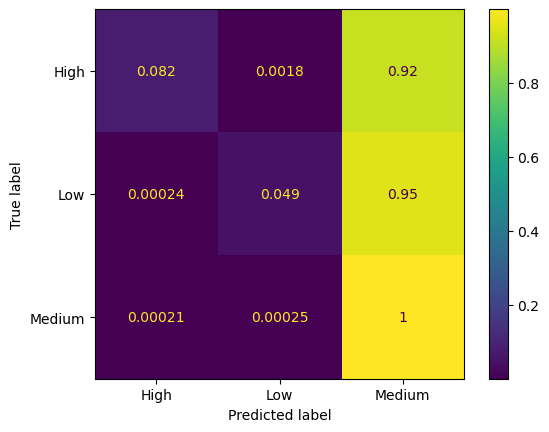

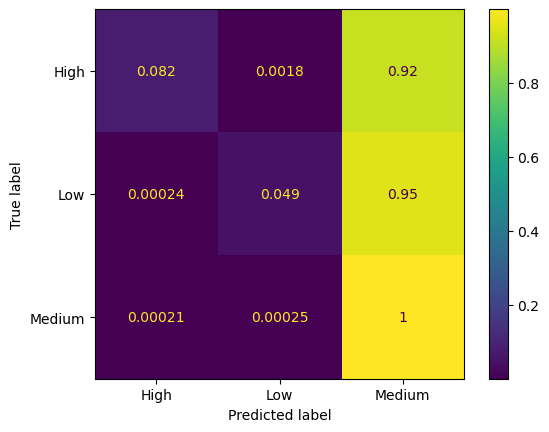

In [9]:
y_pred = best_rf_au.predict(X_test_au)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_au, y_pred, normalize="true").plot()

<Axes: >

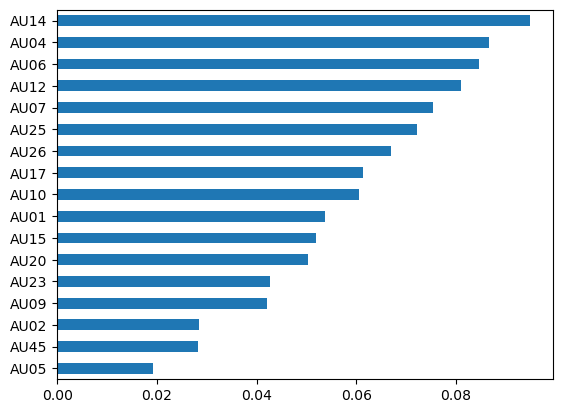

In [10]:
feature_importance_au = pd.Series(best_rf_au.feature_importances_, index=X_train_au.columns).sort_values(ascending=True)
feature_importance_au.plot.barh()

In [11]:
#split dataset in features and target variable

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f_full = re.compile(r"f\d+_(mean|sum|sd|change|max)")

# Extract matching column names
feature_cols_f_full = [col_name for col_name in d_au_pleasantness.columns if pattern_f_full.match(col_name)]
X_ff = d_au_pleasantness[feature_cols_f_full] # Features
y_ff = d_au_pleasantness["pleasantness"] # Target variable


X_train_ff, X_test_ff, y_train_ff, y_test_ff = train_test_split(X_ff, y_ff, test_size=0.3, random_state=1) # 70% training and 30% test

In [12]:
# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f_full)))]}

rf = RandomForestClassifier()

grid_seach_ff = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_ff.fit(X_train_ff, y_train_ff)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [4, 6, 8, 10],
                         'max_features': [5], 'n_estimators': [10, 30, 50]},
             scoring='accuracy')

In [13]:
print(grid_seach_ff.best_params_)
print(grid_seach_ff.score(X_train_ff, y_train_ff))
best_rf_ff = grid_seach_ff.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
0.8298288747813536


In [14]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f_full))), random_state=1)

average_classification_ff = []
f1_score_list_ff = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_ff, y_ff, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_ff.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_ff.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_ff))
print(np.mean(f1_score_list_ff))

Accuracy: 0.8213317350229757
F1: 0.7533139616389647
Accuracy: 0.8263549961469304
F1: 0.760516720361355
Accuracy: 0.8250135570967834
F1: 0.7586343427523872
Accuracy: 0.8270114450438109
F1: 0.7608596570124428
Accuracy: 0.8257841710192083
F1: 0.7585916772945133
Accuracy: 0.8232439992008448
F1: 0.7556439795641201
Accuracy: 0.8282101778120273
F1: 0.7627685950573923
Accuracy: 0.8260125010702971
F1: 0.7591245949868128
Accuracy: 0.8263835374033165
F1: 0.7607613188572142
Accuracy: 0.8265262436852471
F1: 0.7600652661358797
0.8255872363501442
0.7590280113661082


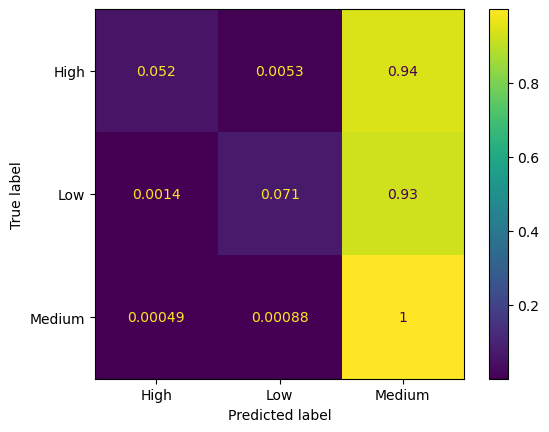

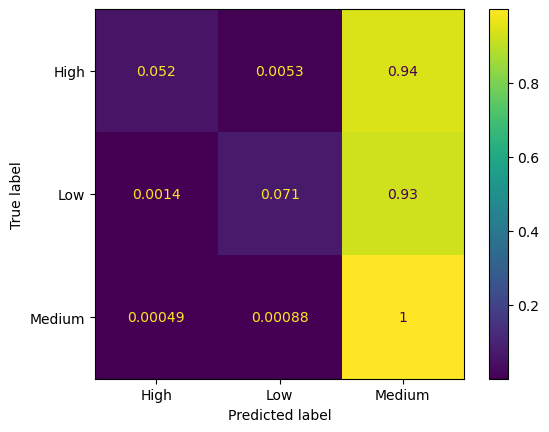

In [15]:
y_pred = best_rf_ff.predict(X_test_ff)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_ff, y_pred, normalize="true").plot()
plt.show()

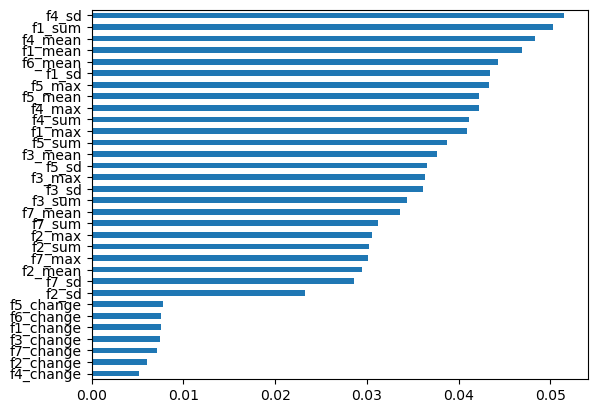

Index(['f4_change', 'f2_change', 'f7_change', 'f3_change', 'f1_change',
       'f6_change', 'f5_change', 'f2_sd', 'f7_sd', 'f2_mean', 'f7_max',
       'f2_sum', 'f2_max', 'f7_sum', 'f7_mean', 'f3_sum', 'f3_sd', 'f3_max',
       'f5_sd', 'f3_mean', 'f5_sum', 'f1_max', 'f4_sum', 'f4_max', 'f5_mean',
       'f5_max', 'f1_sd', 'f6_mean', 'f1_mean', 'f4_mean', 'f1_sum', 'f4_sd'],
      dtype='object')


In [16]:
feature_importance_ff = pd.Series(best_rf_ff.feature_importances_, index=X_train_ff.columns).sort_values(ascending=True)
feature_importance_ff.plot.barh()

plt.show()
print(feature_importance_ff.index)

In [17]:
#split dataset in features and target variable

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f = [col_name for col_name in d_au_pleasantness.columns if pattern_f.match(col_name)]
X_f = d_au_pleasantness[feature_cols_f] # Features
y_f = d_au_pleasantness["pleasantness"] # Target variable


X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.3, random_state=1) # 70% training and 30% test

In [18]:
# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f)))]}

rf = RandomForestClassifier()
# #£££#wdsdljsldj 
grid_seach_f = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f.fit(X_train_f, y_train_f)
print(grid_seach_f.best_params_)
print(grid_seach_f.score(X_train_f, y_train_f))
best_rf_f = grid_seach_f.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 10}
0.8315658140985652


In [19]:
print(grid_seach_f.best_params_)
print(grid_seach_f.score(X_train_f, y_train_f))
best_rf_f = grid_seach_f.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 10}
0.8315658140985652


In [20]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f))))

average_classification_f = []
f1_score_list_f = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f))
print(np.mean(f1_score_list_f))

Accuracy: 0.8269829037874247
F1: 0.7623216894364958
Accuracy: 0.8266118674544053
F1: 0.7610605240620523
Accuracy: 0.8282672603247995
F1: 0.7640030723650026
Accuracy: 0.8301224419898964
F1: 0.7672196131805404
Accuracy: 0.829494534349402
F1: 0.7654431821714224
Accuracy: 0.8261266660958415
F1: 0.7623302753983333
Accuracy: 0.8279247652481663
F1: 0.7641590844729316
Accuracy: 0.8298370294260353
F1: 0.7666595200904736
Accuracy: 0.8264120786597026
F1: 0.7623673231949042
Accuracy: 0.8239575306104975
F1: 0.7580197067719718
0.8275737077946171
0.7633583991144127


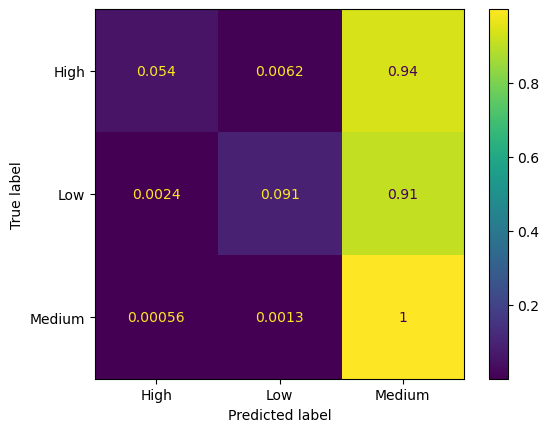

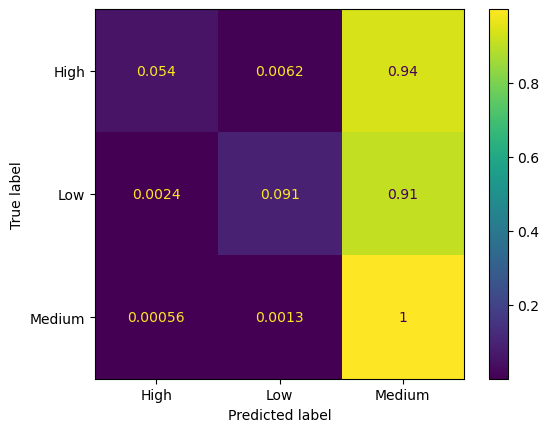

In [21]:
y_pred = best_rf_f.predict(X_test_f)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f, y_pred, normalize="true").plot()

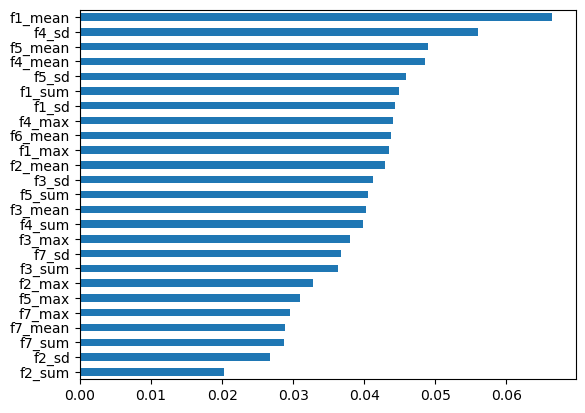

Index(['f2_sum', 'f2_sd', 'f7_sum', 'f7_mean', 'f7_max', 'f5_max', 'f2_max',
       'f3_sum', 'f7_sd', 'f3_max', 'f4_sum', 'f3_mean', 'f5_sum', 'f3_sd',
       'f2_mean', 'f1_max', 'f6_mean', 'f4_max', 'f1_sd', 'f1_sum', 'f5_sd',
       'f4_mean', 'f5_mean', 'f4_sd', 'f1_mean'],
      dtype='object')


In [22]:
feature_importance_f = pd.Series(best_rf_f.feature_importances_, index=X_train_f.columns).sort_values(ascending=True)
feature_importance_f.plot.barh()

plt.show()
print(feature_importance_f.index)

## SMOTE (oversampling)

##### AU oversampling

In [7]:
smote=SMOTE(sampling_strategy="auto")
print(y_au.value_counts())
X_au_smote, y_au_smote = smote.fit_resample(X_au, y_au)
print(y_au_smote.value_counts())



pleasantness
Medium    94980
Low       14094
High       7716
Name: count, dtype: int64
pleasantness
Medium    94980
High      94980
Low       94980
Name: count, dtype: int64


In [24]:
# Au oversampling
X_train_au_smote, X_test_au_smote, y_train_au_smote, y_test_au_smote = train_test_split(X_au_smote, y_au_smote, test_size=0.3, random_state=1) # 70% training and 30% test

In [25]:
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_au)))]}

rf = RandomForestClassifier()

grid_seach_au_smote = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_au_smote.fit(X_train_au_smote, y_train_au_smote)

print(grid_seach_au_smote.best_params_)
print(grid_seach_au_smote.score(X_train_au_smote, y_train_au_smote))
best_rf_au_smote = grid_seach_au_smote.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.850444705150959


In [26]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_au))), random_state=1)

average_classification_au_smote = []
f1_score_list_au_smote = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au_smote, y_au_smote, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_au_smote.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_au_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_au_smote))
print(np.mean(f1_score_list_au_smote))

Accuracy: 0.8416274771296881
F1: 0.8397521272550318
Accuracy: 0.8447158466109824
F1: 0.8427699702882236
Accuracy: 0.8484242296623851
F1: 0.8465707103344666
Accuracy: 0.8432184553473245
F1: 0.8412243966732474
Accuracy: 0.8412999227907629
F1: 0.8393846928582577
Accuracy: 0.8404108467279662
F1: 0.8382210645972631
Accuracy: 0.838223251678716
F1: 0.8361532486687006
Accuracy: 0.8465641889520601
F1: 0.844765910374495
Accuracy: 0.8456985096277579
F1: 0.8438721850003114
Accuracy: 0.8436863901172177
F1: 0.8415464055958658
0.8433869118644861
0.8414260711645862


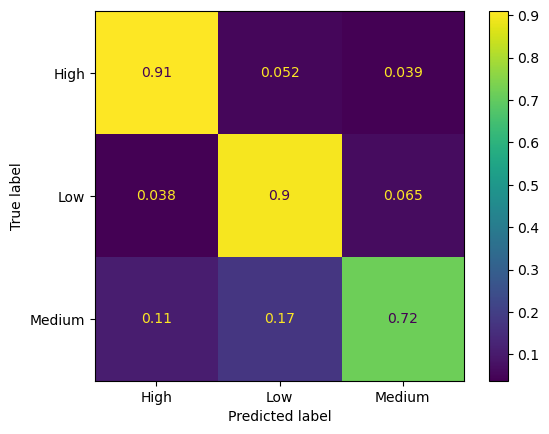

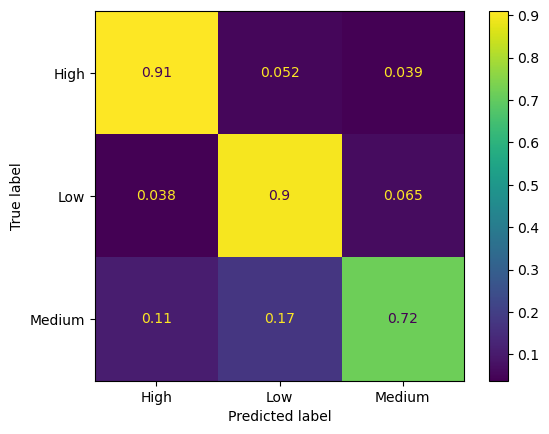

<Axes: >

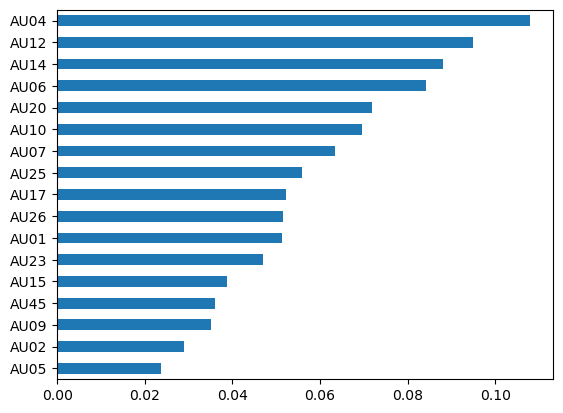

In [27]:
y_pred = best_rf_au_smote.predict(X_test_au_smote)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_au_smote, y_pred, normalize="true").plot()
plt.show()
feature_importance_au_smote = pd.Series(best_rf_au_smote.feature_importances_, index=X_train_au.columns).sort_values(ascending=True)
feature_importance_au_smote.plot.barh()

### BASE model

In [28]:
average_classification_smote = []
f1_score_list_smote = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au_smote, y_au_smote, test_size=0.3) # 70% training and 30% test

    #Predict the response for test dataset
    y_pred = ["Medium"] * len(y_test)

    average_classification_smote.append(metrics.accuracy_score(y_test, y_pred))
    
    # Calculate F1 score for each class separately

    # f1_per_class = f1_score(y_test, y_pred, average=None)
    # print(f1_per_class)

    # Calculate micro-average F1 score
    # f1_micro = f1_score(y_test, y_pred, average='micro')

    # Calculate macro-average F1 score
    # f1_macro = f1_score(y_test, y_pred, average='macro')

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))

print(np.mean(average_classification_smote))
print(np.mean(f1_score_list_smote))

Accuracy: 0.333894855057205
F1: 0.16715826410304402
Accuracy: 0.3322921784703212
F1: 0.1657565715042011
Accuracy: 0.3324559556397838
F1: 0.16589961112416954
Accuracy: 0.3350997870896797
F1: 0.16821494302284076
Accuracy: 0.33398844201118366
F1: 0.1672402486919337
Accuracy: 0.33208160782386936
F1: 0.165572730089773
Accuracy: 0.3343159963501088
F1: 0.16752731095376833
Accuracy: 0.333356730071828
F1: 0.16668713927471634
Accuracy: 0.3329238904096769
F1: 0.1663085456011268
Accuracy: 0.3336491893030112
F1: 0.16694312479691206
0.33340586322266674
0.16673084891624856


### Factor subset

In [29]:
# Create the factors on the smote'd dataset
X_f_smote = X_au_smote
y_f_smote = y_au_smote.copy()

# weighted mean activation
X_f_smote["f1_mean"]  = X_f_smote[f1].mul(f1_weights).sum(axis=1)/len(f1)
X_f_smote["f2_mean"]  = X_f_smote[f2].mul(f2_weights).sum(axis=1)/len(f2)
X_f_smote["f3_mean"]  = X_f_smote[f3].mul(f3_weights).sum(axis=1)/len(f3)
X_f_smote["f4_mean"]  = X_f_smote[f4].mul(f4_weights).sum(axis=1)/len(f4)
X_f_smote["f5_mean"]  = X_f_smote[f5].mul(f5_weights).sum(axis=1)/len(f5)
X_f_smote["f6_mean"]  = X_f_smote[f6].mul(f6_weights).sum(axis=1)/len(f6)
X_f_smote["f7_mean"]  = X_f_smote[f7].mul(f7_weights).sum(axis=1)/len(f7)

# weighted sum variables
X_f_smote["f1_sum"]  = X_f_smote[f1].mul(f1_weights).sum(axis=1)
X_f_smote["f2_sum"]  = X_f_smote[f2].mul(f2_weights).sum(axis=1)
X_f_smote["f3_sum"]  = X_f_smote[f3].mul(f3_weights).sum(axis=1)
X_f_smote["f4_sum"]  = X_f_smote[f4].mul(f4_weights).sum(axis=1)
X_f_smote["f5_sum"]  = X_f_smote[f5].mul(f5_weights).sum(axis=1)
X_f_smote["f7_sum"]  = X_f_smote[f7].mul(f7_weights).sum(axis=1)


# sd
X_f_smote["f1_sd"]  = X_f_smote[f1].mul(f1_weights).std(axis=1)
X_f_smote["f2_sd"]  = X_f_smote[f2].mul(f2_weights).std(axis=1)
X_f_smote["f3_sd"]  = X_f_smote[f3].mul(f3_weights).std(axis=1)
X_f_smote["f4_sd"]  = X_f_smote[f4].mul(f4_weights).std(axis=1)
X_f_smote["f5_sd"]  = X_f_smote[f5].mul(f5_weights).std(axis=1)
X_f_smote["f7_sd"]  = X_f_smote[f7].mul(f7_weights).std(axis=1)

# max
X_f_smote["f1_max"]  = X_f_smote[f1].mul(f1_weights).max(axis=1)
X_f_smote["f2_max"]  = X_f_smote[f2].mul(f2_weights).max(axis=1)
X_f_smote["f3_max"]  = X_f_smote[f3].mul(f3_weights).max(axis=1)
X_f_smote["f4_max"]  = X_f_smote[f4].mul(f4_weights).max(axis=1)
X_f_smote["f5_max"]  = X_f_smote[f5].mul(f5_weights).max(axis=1)
X_f_smote["f7_max"]  = X_f_smote[f7].mul(f7_weights).max(axis=1)

X_f_smote = X_f_smote[feature_cols_f]

In [30]:
X_train_f_smote, X_test_f_smote, y_train_f_smote, y_test_f_smote = train_test_split(X_f_smote, y_f_smote, test_size=0.3, random_state=1) # 70% training and 30% test

# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f)))]}

rf = RandomForestClassifier()

grid_seach_f_smote = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f_smote.fit(X_train_f_smote, y_train_f_smote)

# best parameters
print(grid_seach_f_smote.best_params_)
print(grid_seach_f_smote.score(X_train_f_smote, y_train_f_smote))
best_rf_f_smote = grid_seach_f_smote.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
0.7816883754975985


In [31]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f))))

average_classification_f_smote = []
f1_score_list_f_smote = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f_smote, y_f_smote, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f_smote.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f_smote))
print(np.mean(f1_score_list_f_smote))


Accuracy: 0.7755433892515383
F1: 0.7741690511796993
Accuracy: 0.777964951685735
F1: 0.7769500065536123
Accuracy: 0.7760113240214314
F1: 0.7745149930375042
Accuracy: 0.7853583210500457
F1: 0.7837648487104769
Accuracy: 0.7740693947263751
F1: 0.7729861580223916
Accuracy: 0.7738939191876653
F1: 0.7723987792357248
Accuracy: 0.7787955359022952
F1: 0.777327376134331
Accuracy: 0.7742799653728271
F1: 0.772932496984579
Accuracy: 0.7734961746332562
F1: 0.7722250994174422
Accuracy: 0.76884022367282
F1: 0.7675517399122203
0.7758253199503989
0.7744820549187982


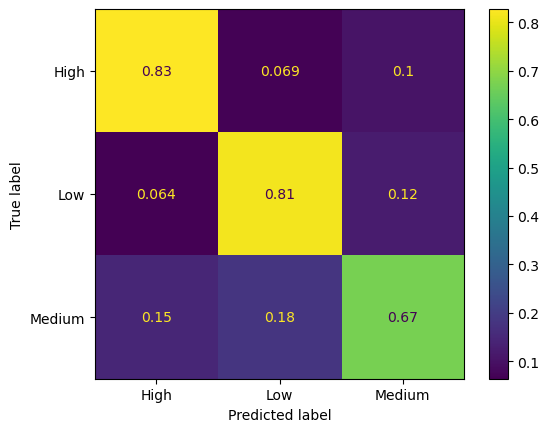

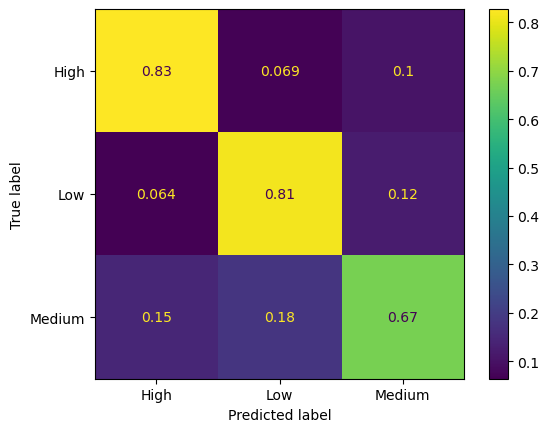

<Axes: >

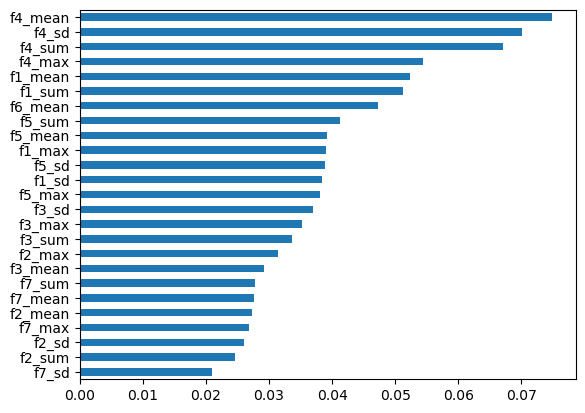

In [32]:
y_pred = best_rf_f_smote.predict(X_test_f_smote)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f_smote, y_pred, normalize="true").plot()
plt.show()
feature_importance_f_smote = pd.Series(best_rf_f_smote.feature_importances_, index=X_train_f_smote.columns).sort_values(ascending=True)
feature_importance_f_smote.plot.barh()

In [36]:
print(list(feature_importance_au_smote.index))

['AU05', 'AU02', 'AU09', 'AU45', 'AU15', 'AU23', 'AU01', 'AU26', 'AU17', 'AU25', 'AU07', 'AU10', 'AU20', 'AU06', 'AU14', 'AU12', 'AU04']


## Stratou

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.8129280349747816
Accuracy: 0.799466554362322
F1: 0.7978969205626786
Accuracy: 0.7941671930932828
F1: 0.7926044852159169
Accuracy: 0.8021454809199597
F1: 0.8006670482438851
Accuracy: 0.7989401277461922
F1: 0.7975372512661504
Accuracy: 0.7989752228539342
F1: 0.7974667947516308
Accuracy: 0.7946585246016705
F1: 0.7926773493549889
Accuracy: 0.8003673287943661
F1: 0.7988685410741679
Accuracy: 0.7939098289698416
F1: 0.792078482134411
Accuracy: 0.7945181441707027
F1: 0.7932206282202222
Accuracy: 0.7990922065464074
F1: 0.7974410975178239
0.797624061205868
0.7960458598341875


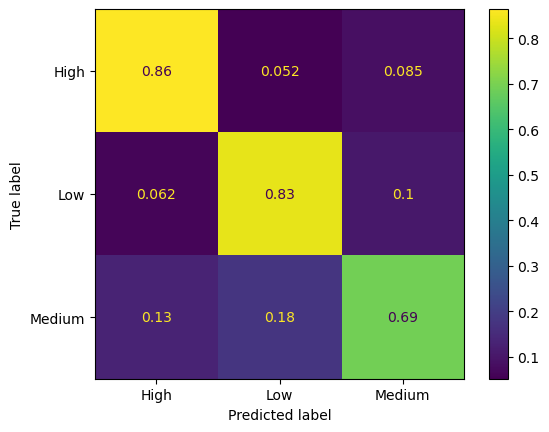

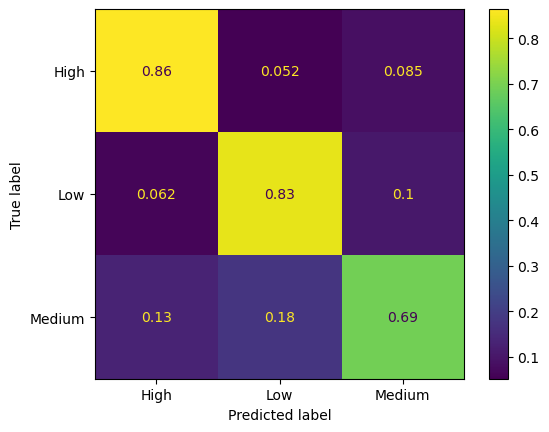

<Axes: >

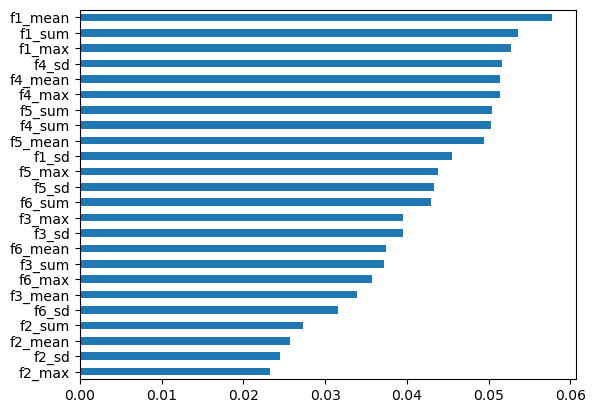

In [28]:
f1_strat = ["AU06", "AU07", "AU12"]
f1_weights_strat = [0.982, 0.446, 0.882]
f2_strat = ["AU01", "AU02"]
f2_weights_strat = [0.981, 0.873]
f3_strat = ["AU20", "AU25", "AU26"]
f3_weights_strat = [0.377, 0.951, 0.786]
f4_strat = ["AU14", "AU17", "AU23"]
f4_weights_strat = [0.724, 0.632, 0.710]
f5_strat = ["AU04", "AU07", "AU09"]
f5_weights_strat = [0.703, 0.384, 0.390]
f6_strat = ["AU10", "AU15", "AU17"]
f6_weights_strat = [0.488, 0.504, 0.420]

# Create the factors on the smote'd dataset
X_f_smote_strat = X_au_smote.copy()
y_f_smote_strat = y_au_smote.copy()

# weighted mean activation
X_f_smote_strat["f1_mean"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).sum(axis=1)/len(f1_strat)
X_f_smote_strat["f2_mean"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).sum(axis=1)/len(f2_strat)
X_f_smote_strat["f3_mean"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).sum(axis=1)/len(f3_strat)
X_f_smote_strat["f4_mean"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).sum(axis=1)/len(f4_strat)
X_f_smote_strat["f5_mean"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).sum(axis=1)/len(f5_strat)
X_f_smote_strat["f6_mean"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).sum(axis=1)/len(f6_strat)

# weighted sum variables
X_f_smote_strat["f1_sum"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).sum(axis=1)
X_f_smote_strat["f2_sum"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).sum(axis=1)
X_f_smote_strat["f3_sum"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).sum(axis=1)
X_f_smote_strat["f4_sum"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).sum(axis=1)
X_f_smote_strat["f5_sum"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).sum(axis=1)
X_f_smote_strat["f6_sum"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).sum(axis=1)


# sd
X_f_smote_strat["f1_sd"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).std(axis=1)
X_f_smote_strat["f2_sd"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).std(axis=1)
X_f_smote_strat["f3_sd"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).std(axis=1)
X_f_smote_strat["f4_sd"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).std(axis=1)
X_f_smote_strat["f5_sd"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).std(axis=1)
X_f_smote_strat["f6_sd"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).std(axis=1)

# max
X_f_smote_strat["f1_max"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).max(axis=1)
X_f_smote_strat["f2_max"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).max(axis=1)
X_f_smote_strat["f3_max"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).max(axis=1)
X_f_smote_strat["f4_max"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).max(axis=1)
X_f_smote_strat["f5_max"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).max(axis=1)
X_f_smote_strat["f6_max"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).max(axis=1)

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f_strat = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f_strat = [col_name for col_name in X_f_smote_strat.columns if pattern_f_strat.match(col_name)]

X_f_smote_strat = X_f_smote_strat[feature_cols_f_strat]

# divide 
X_train_f_smote_strat, X_test_f_smote_strat, y_train_f_smote_strat, y_test_f_smote_strat = train_test_split(X_f_smote_strat, y_f_smote_strat, test_size=0.3, random_state=1) # 70% training and 30% test

# # grid search for factor tree
# param_grid = {"n_estimators": [10, 30, 50],
#               "max_depth": [4, 6, 8, 10],
#               "criterion": ["gini"],
#               "max_features": [int(np.sqrt(len(feature_cols_f_strat)))]}

# rf = RandomForestClassifier()

# grid_seach_f_smote_strat = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

# grid_seach_f_smote_strat.fit(X_train_f_smote_strat, y_train_f_smote_strat)

# best parameters
print(grid_seach_f_smote_strat.best_params_)
print(grid_seach_f_smote_strat.score(X_train_f_smote_strat, y_train_f_smote_strat))
best_rf_f_smote_strat = grid_seach_f_smote_strat.best_estimator_


# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f_strat))))

average_classification_f_smote_strat = []
f1_score_list_f_smote_strat = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f_smote_strat, y_f_smote_strat, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f_smote_strat.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f_smote_strat.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f_smote_strat))
print(np.mean(f1_score_list_f_smote_strat))

# plots
y_pred = best_rf_f_smote_strat.predict(X_test_f_smote_strat)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f_smote_strat, y_pred, normalize="true").plot()
plt.show()
feature_importance_f_smote_strat = pd.Series(best_rf_f_smote_strat.feature_importances_, index=X_train_f_smote_strat.columns).sort_values(ascending=True)
feature_importance_f_smote_strat.plot.barh()

In [41]:
print(list(feature_importance_f_smote_strat.index))


['f2_max', 'f2_sd', 'f2_mean', 'f2_sum', 'f6_sd', 'f3_mean', 'f6_max', 'f3_sum', 'f6_mean', 'f3_sd', 'f3_max', 'f6_sum', 'f5_sd', 'f5_max', 'f1_sd', 'f5_mean', 'f4_sum', 'f5_sum', 'f4_max', 'f4_mean', 'f4_sd', 'f1_max', 'f1_sum', 'f1_mean']


<Axes: >

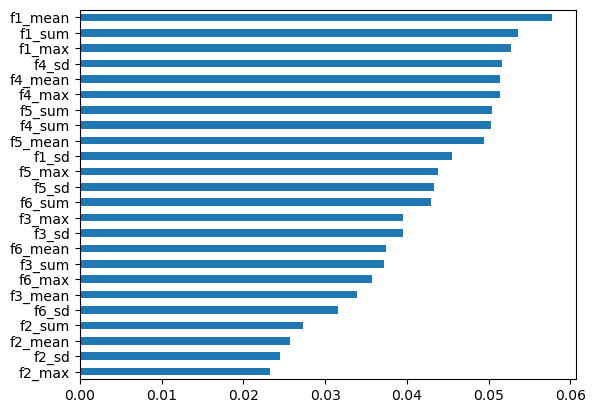

In [35]:
feature_importance_f_smote_strat = pd.Series(best_rf_f_smote_strat.feature_importances_, index=X_train_f_smote_strat.columns).sort_values(ascending=True)
feature_importance_f_smote_strat.plot.barh()

In [37]:
feature_importance_f_smote_strat.index

Index(['f2_max', 'f2_sd', 'f2_mean', 'f2_sum', 'f6_sd', 'f3_mean', 'f6_max',
       'f3_sum', 'f6_mean', 'f3_sd', 'f3_max', 'f6_sum', 'f5_sd', 'f5_max',
       'f1_sd', 'f5_mean', 'f4_sum', 'f5_sum', 'f4_max', 'f4_mean', 'f4_sd',
       'f1_max', 'f1_sum', 'f1_mean'],
      dtype='object')